In [1]:
import polars as pl
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
from pathlib import Path

data_dir = Path("../data")

full = pl.scan_parquet(data_dir / "joined_data_train_3.parquet")

In [2]:
df_labeled = (
  full
  .filter(pl.col("label") != "UNKNOWN")
  .select("transaction_id", "category", "label")
  .with_columns(pl.col("category").fill_null("missing"))
)

In [3]:
def generate_category_list(df: pl.LazyFrame) -> pl.LazyFrame:
    """
    Generate a list of unique categories for each transaction_id.
    """
    categories_by_transaction = (
        df.group_by("transaction_id")
        .agg([
            pl.col("category").alias("category_list"),
            pl.col("label")
        ])
        .with_columns(
            pl.concat_list([pl.col("category_list"), pl.col("label")]).list.unique().alias("category_list_with_label")
        )
        .select("transaction_id", "category_list_with_label")
    )
    return categories_by_transaction.collect().select("category_list_with_label").to_series().to_list()

In [4]:
label_counts = df_labeled.group_by("transaction_id").agg(pl.col("label").first()).group_by("label").agg(pl.len()).collect()
n_fraud = label_counts.filter(pl.col("label") == "FRAUD")["len"][0]
n_normal = label_counts.filter(pl.col("label") == "NORMAL")["len"][0]

In [5]:
transactions = generate_category_list(df_labeled)
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)
df.drop(columns=["NORMAL"], inplace=True)

In [6]:
df_cats = df.groupby("FRAUD").sum().T
df_cats_proportional = df_cats.div(df_cats.sum(axis=1), axis=0)
# filter out line with "missing" - always fraud
df_cats_proportional = df_cats_proportional[df_cats_proportional.index != "missing"]
df_cats

FRAUD,False,True
ALCOHOL,2369,49
BAKERY,1930,59
BEVERAGES,99448,3236
CONVENIENCE,25779,1025
DAIRY,39887,1420
FROZEN_GOODS,58849,1819
FRUITS_VEGETABLES,3196,142
FRUITS_VEGETABLES_PIECES,121700,3831
HOUSEHOLD,5251,169
LONG_SHELF_LIFE,34631,999


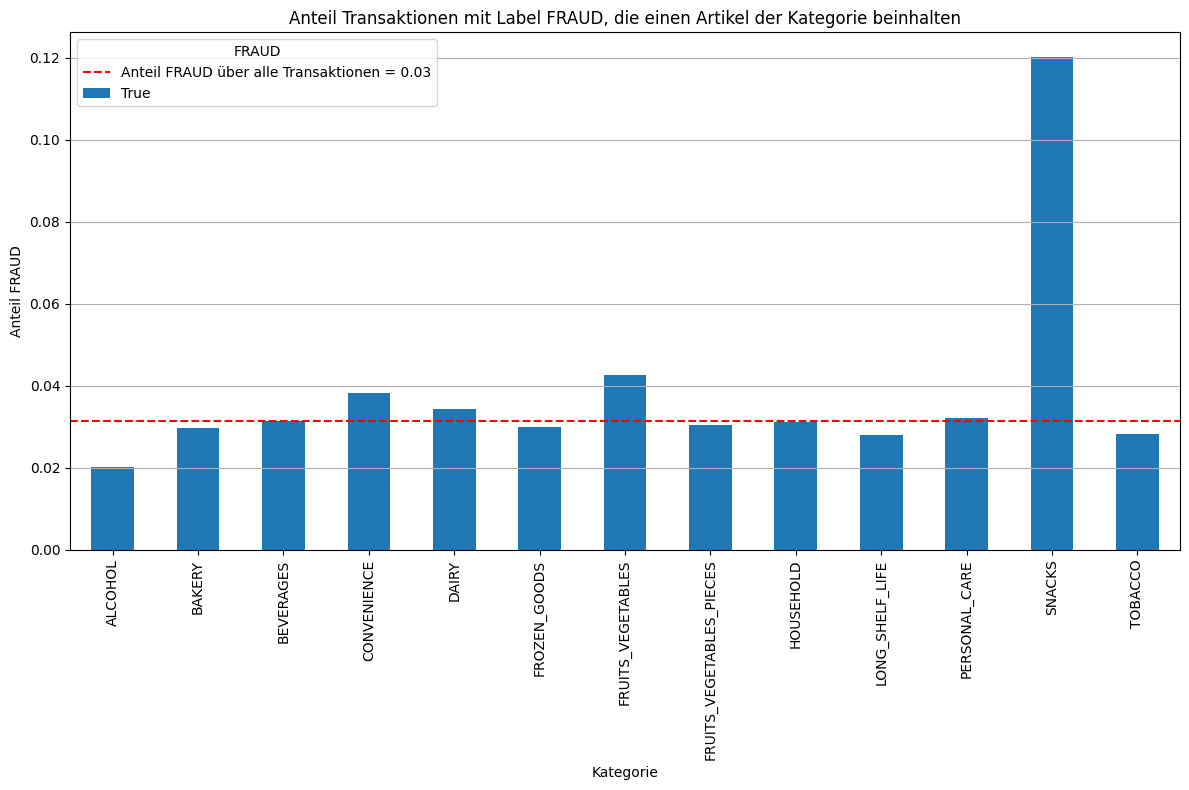

In [7]:
df_cats_proportional[True].plot(kind='bar', figsize=(12, 8))
plt.title(f'Anteil Transaktionen mit Label FRAUD, die einen Artikel der Kategorie beinhalten')
plt.xlabel("Kategorie")
plt.ylabel('Anteil FRAUD')
p_fraud = n_fraud / (n_fraud + n_normal)
plt.axhline(y=p_fraud, color='red', linestyle='--', label=f'Anteil FRAUD über alle Transaktionen = {p_fraud:.2f}')
plt.legend(title='FRAUD')
plt.grid(axis='y')
plt.tight_layout()
plt.show()